# Raibert Hopper (ish) Simulation

This notebook demonstrates a one-legged hopping robot controlled using (mostly) the Raibert control algorithm. 

For the person interested in biomechanics this notebook's goal is to 
- not make you think about a complicated hopping thing! It is a telecoping leg, and a torso (sort of looks like a trapeze artist!), and that's it!
-  consider how we might do control of running in a simple way

How did Marc Raibert and his MIT lab do this 'simple' way? 

The hopper keeps three main control strategies in mind for 2D running:
1. **Foot placement** for forward speed control adjust the foot
2. **Thrust timing** keep the amount of energy added to the hopper roughly the same each time, by keeping push-off duration roughly fixed. 
3. **Body attitude** Stabilze body during stance

This sure seems a lot simpler than what our brains do when we run! I wouldn't guess that the solution to running is divided up into three separate ideas lke that. One way to get 'off the ground' for any hard control problem is to just try it, based on some observational intuition.

Let's deal with the problem of running by thinking about simplifying assumptions for running. As Monte Python might demonstrate, there are any number of funny ways to move from A to B, and this is no less true for running. But imagine that one simplifying true thing for running at a steady speed is that, over a pushoff on the ground, to stay at steady speed, there must be no net change in acceleration of the body over that period; ie, the forces during stance must integrate to zero. Now, there are many (actually, infinite!) force profiles that will do that, but Raibert points out that one simple set of solutions are the set of position functions that have different kinds of symmetry. 

You might plot the motion of the body around this contact point. If you think about it, this path is roughly symmetric in space and time. Spatially this means that the about the placement of the foot's placement. In fact, a 1986 Science paper from Marc Raibert focused on this symmetry, and proposed this simplifying assumption for ground contact. 
   


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os,sys

localpath = 'assets/raibert_hopper_schematic.png'

img = mpimg.imread(os.path.join(os.getcwd(),localpath))

plt.figure(figsize=(10, 8))  # width, height in inches
plt.imshow(img)
plt.axis('off')
plt.show()

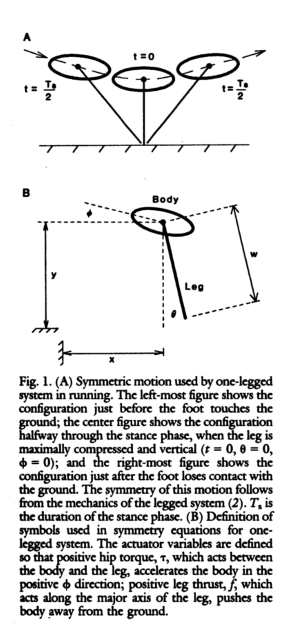

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os,sys

localpath = 'assets/raibert_hopper_schematic.png'

img = mpimg.imread(os.path.join(os.getcwd(),localpath))

plt.figure(figsize=(10, 8))  # width, height in inches
plt.imshow(img)
plt.axis('off')
plt.show()

In [56]:
# Install dependencies with specific versions for reproducibility
# Uncomment and run if packages are missing or you want exact versions
# !pip install numpy==2.3.3 matplotlib==3.10.6 scipy==1.16.2

# For MeshCat 3D visualization (optional):
# !pip install meshcat

# Note: Colab comes with numpy, matplotlib, and scipy pre-installed.
# The versions above match the development environment (Python 3.14).
# The code should work with most recent versions of these packages.

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, cumulative_trapezoid
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
from dataclasses import dataclass
import time
import copy

## Parameters Class

In [58]:
@dataclass
class Parameters:
    """Parameters class for hopper simulation"""
    # Physical parameters
    m: float = 10.0        # mass of the body
    m_l: float = 1.0       # mass of the leg
    J: float = 10.0        # moment of inertia of the body
    J_l: float = 1.0       # moment of inertia of the leg
    g: float = 9.8         # gravity
    k_l: float = 1e3       # spring constant of leg spring
    k_stop: float = 2e5    # spring constant of leg stop
    b_stop: float = 1e3    # damping constant of leg stop
    k_g: float = 1e4       # spring constant of the ground
    b_g: float = 300.0     # damping constant of the ground
    r_s0: float = 1.0      # rest length of the leg spring
    l_1: float = 0.5       # distance from the foot to the com of the leg
    l_2: float = 0.4       # distance from the hip to the com of the body

    # FSM states
    FSM_COMPRESSION: int = 0
    FSM_THRUST: int = 1
    FSM_LOADING: int = 99
    FSM_FLIGHT: int = 2
    FSM_NUM_STATES: int = 3

    # State parameters
    fsm_state: int = 2  # FSM_FLIGHT - usually we start in the air
    t_state_switch: float = 0.0
    x_dot_des: float = 0.0
    T_s: float = 0.425  # Stance time estimate
    T_compression: float = 0.0
    t_thrust_on: float = 0.0
    T_MAX_THRUST_DUR: float = 0.425 * 0.35

    toString: str = '1: x foot 2: y foot 3: abs angle leg (vert) 4: abs angle body (vert) 5:leg length'


def hopperParameters():
    """function p = hopperParameters()"""
    return Parameters()

## Control System

In [59]:
def hopperStateControl(t, q, param):
    """function [u,internalStruct] = hopperStateControl(t,q,param)"""
    THRUST = param.FSM_THRUST
    COMPRESSION = param.FSM_COMPRESSION
    FLIGHT = param.FSM_FLIGHT

    # Control gains
    k_fp = 150.0   # foot placement gain
    b_fp = 15.0    # foot placement damping
    k_att = 150.0  # attitude gain
    b_att = 15.0   # attitude damping
    k_xdot = 0.02  # forward speed gain
    thrust = 0.035 * param.k_l  # thrust force
    thr_z_low = 0.01
    u_retract = -0.1 * param.k_l

    if param.T_s == 0:
        print('Warning: using default T_s.')
        T_s = 0.425
    else:
        T_s = param.T_s

    u = np.array([0.0, 0.0])
    a_des = 0
    
    d_xfoot_dt = q[5]
    y_foot = q[1]
    a = q[2]
    dadt = q[7]
    b = q[3]
    dbdt = q[8]
    l = q[4]
    dldt = q[9]
    stance_ang_des = a / 2

    if param.fsm_state == THRUST:
        u[0] = thrust
        u[1] = -k_att * (b - stance_ang_des) - b_att * dbdt
    elif param.fsm_state == COMPRESSION:
        u[1] = -k_att * (b - stance_ang_des) - b_att * dbdt
    elif param.fsm_state == FLIGHT:
        d_xbody_dt = d_xfoot_dt + dldt * np.sin(a) + l * np.cos(a) * dadt + param.l_2 * np.cos(b) * dbdt
        a_des = -np.arcsin((1 * d_xbody_dt * T_s / 2 + k_xdot * (d_xbody_dt - param.x_dot_des)) / l)
        if np.isnan(a_des):
            print('warning! nan in a_des. an error has occurred.')
        if y_foot > thr_z_low:
            u[1] = k_fp * (a - a_des) + b_fp * (dadt)

    # Thrust duration limiting
    if param.fsm_state == THRUST:
        if t - param.t_thrust_on > param.T_MAX_THRUST_DUR:
            u[0] = 0
    
    return u, a_des

## Dynamics

In [60]:
def hopperDynamicsFwd(t, q, p_obj):
    """function structOut = hopperDynamicsFwd(t,q,p_obj)"""
    u, a_des = hopperStateControl(t, q, p_obj)
    R = q[4] - p_obj.l_1
    s1 = np.sin(q[2])
    c1 = np.cos(q[2])
    s2 = np.sin(q[3])
    c2 = np.cos(q[3])

    r_sd = p_obj.r_s0 - q[4]
    if r_sd > 0:
        F_k = p_obj.k_l * r_sd + u[0]
    else:
        F_k = p_obj.k_stop * r_sd + u[0] - p_obj.b_stop * q[9]

    if q[1] < 0:
        F_x = -p_obj.b_g * q[5]
        F_z = p_obj.k_g * (-q[1])
        F_z = F_z + max(-p_obj.b_g * q[6], 0.0)
    else:
        F_x = 0.0
        F_z = 0.0

    a = p_obj.l_1 * F_z * s1 - p_obj.l_1 * F_x * c1 - u[1]

    M = np.array([
        [-p_obj.m_l * R, 0, (p_obj.J_l - p_obj.m_l * R * p_obj.l_1) * c1, 0, 0],
        [0, p_obj.m_l * R, (p_obj.J_l - p_obj.m_l * R * p_obj.l_1) * s1, 0, 0],
        [p_obj.m * R, 0, (p_obj.J_l + p_obj.m * R * q[4]) * c1, p_obj.m * R * p_obj.l_2 * c2, p_obj.m * R * s1],
        [0, -p_obj.m * R, (p_obj.J_l + p_obj.m * R * q[4]) * s1, p_obj.m * R * p_obj.l_2 * s2, -p_obj.m * R * c1],
        [0, 0, p_obj.J_l * p_obj.l_2 * np.cos(q[2] - q[3]), -p_obj.J * R, 0]
    ])

    eta = np.array([
        a * c1 - R * (F_x - F_k * s1 - p_obj.m_l * p_obj.l_1 * q[7] * q[7] * s1),
        a * s1 + R * (p_obj.m_l * p_obj.l_1 * q[7] * q[7] * c1 + F_z - F_k * c1 - p_obj.m_l * p_obj.g),
        a * c1 + R * F_k * s1 + p_obj.m * R * (q[4] * q[7] * q[7] * s1 + p_obj.l_2 * q[8] * q[8] * s2 - 2 * q[9] * q[7] * c1),
        a * s1 - R * (F_k * c1 - p_obj.m * p_obj.g) - p_obj.m * R * (2 * q[9] * q[7] * s1 + q[4] * q[7] * q[7] * c1 + p_obj.l_2 * q[8] * q[8] * c2),
        a * p_obj.l_2 * np.cos(q[2] - q[3]) - R * (p_obj.l_2 * F_k * np.sin(q[3] - q[2]) + u[1])
    ])

    qdd = np.linalg.solve(M, eta)
    xdot = np.concatenate([q[5:10], qdd])

    structOut = {}
    structOut['stated'] = xdot
    structOut['u'] = u
    structOut['a_des'] = a_des
    structOut['r_sd'] = r_sd
    structOut['fsm_state'] = p_obj.fsm_state

    return structOut


def hopperDynamics(t, q, p_obj):
    """function qdot = hopperDynamics(t,q,p_obj)"""
    structFwd = hopperDynamicsFwd(t, q, p_obj)
    qdot = structFwd['stated']
    return qdot

## Event Detection (State Machine Transitions)

In [61]:
def eventsHopperControl(t, q, param):
    """function [value,isterminal,direction] = eventsHopperControl(t,q,param)"""
    COMPRESSION = param.FSM_COMPRESSION
    THRUST = param.FSM_THRUST
    FLIGHT = param.FSM_FLIGHT

    y_foot = q[1]
    ddt_leg = q[9]
    l = q[4]
    thresh_leg_extended = 0.0001

    if param.fsm_state == COMPRESSION:
        value = ddt_leg  # go from compression to thrust when leg stops compressing
    elif param.fsm_state == THRUST:
        value = -(param.r_s0 - l) - thresh_leg_extended  # when leg is fully extended
    elif param.fsm_state == FLIGHT:
        value = -y_foot  # touchdown
    else:
        value = 1.0  # Should not reach here

    return value

## Visualization

In [62]:
def draw(p_obj, t, q):
    """function draw(p_obj,t,q)"""
    l_1 = p_obj.l_1
    l_2 = p_obj.l_2

    if not hasattr(draw, 'hFig'):
        draw.hFig = None
        draw.xcamera = 0

    if draw.hFig is None:
        draw.hFig = plt.figure(25, figsize=(10, 6))
        draw.brick1 = np.array([[0.9, 1.05, 1.05, 0.9, 0.9], [0.15, 0.15, 0.0, 0.0, 0.15]])
        draw.brick2 = np.array([[-1, 0], [0, 1]]) @ draw.brick1
        draw.beam = np.array([[-1, -1, 1, 1], [0.15, 0.175, 0.175, 0.15]])
        draw.comp = np.array([[0.25, 0.25, 0.025, 0.025, -0.025, -0.025, -0.25, -0.25],
                               [0.15, 0.3, 0.3, 0.15, 0.15, 0.3, 0.3, 0.15]])
        draw.body = np.hstack([draw.brick1, draw.brick2, draw.beam, draw.comp])
        draw.body = draw.body - np.array([[0], [0.16]]) @ np.ones((1, draw.body.shape[1]))
        draw.leg = np.array([[-0.015, -0.04, -0.04, 0.04, 0.04, 0.015, -0.015],
                              [-0.25, -0.25, 0.525, 0.525, -0.25, -0.25, -0.25]])
        draw.leg = draw.leg - np.array([[0], [0.16]]) @ np.ones((1, draw.leg.shape[1]))
        draw.foot = np.array([[0.0, -0.03, -0.03, 0.015, 0.015, -0.025, -0.025, 0.025, 0.025, -0.015, -0.015, 0.03, 0.03, 0.0],
                               [0.0, 0.05, 0.14, 0.14, 1.675, 1.675, 1.725, 1.725, 1.675, 1.675, 0.14, 0.14, 0.05, 0.0]])

    hip = np.array([0, q[4]])
    rot = np.array([[np.cos(q[2]), np.sin(q[2])], [-np.sin(q[2]), np.cos(q[2])]])
    hip = rot @ hip + np.array([q[0], q[1]])
    cop = np.array([q[0], q[1]])

    Foot = rot @ draw.foot + np.array([[q[0]], [q[1]]])
    Leg = rot @ draw.leg + hip.reshape(2, 1)
    rot = np.array([[np.cos(q[3]), np.sin(q[3])], [-np.sin(q[3]), np.cos(q[3])]])
    Body = rot @ draw.body + hip.reshape(2, 1)

    plt.figure(draw.hFig.number)
    plt.clf()

    draw.xcamera = np.mean([hip[0], draw.xcamera])
    xmin = draw.xcamera - 5
    xmax = draw.xcamera + 5
    ymin = -0.25
    ymax = 3.0

    plt.plot([xmin, xmax], [0, 0], 'k-')
    plt.axis('equal')
    plt.axis([xmin, xmax, ymin, ymax])

    plt.plot(Foot[0, :], Foot[1, :], 'k-')
    plt.plot(Leg[0, :], Leg[1, :], 'k-')
    plt.plot(Body[0, :], Body[1, :], 'k-')
    c = 0.75
    plt.fill(Foot[0, :], Foot[1, :], color=[c, c, c])
    plt.fill(Leg[0, :], Leg[1, :], color=[c, c, c])
    plt.fill(Body[0, :], Body[1, :], color=[c, c, c])

    plt.title(f't={t:.3f} s')

## Main Simulation Function

In [63]:
def call_hopper(tstart=0, tfinal=5, x_dot_des=2.0, y0=None, sr_sim=1000, animate=True):
    """Main simulation script
    
    Args:
        tstart (float): Start time for simulation (default: 0)
        tfinal (float): Final time for simulation (default: 5)
        x_dot_des (float): Desired forward velocity in m/s (default: 2.0)
        y0 (np.array): Initial state vector (default: standard starting state)
        sr_sim (int): Simulation sample rate (default: 1000)
        animate (bool): Whether to create animation (default: True)
    
    Returns:
        tuple: (tout, yout, State, p, anim) where anim is the FuncAnimation object
    """
    # Set default initial conditions if not provided
    if y0 is None:
        y0 = np.array([0.0, 0.4, 0.01, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0])

    p = hopperParameters()
    p.x_dot_des = x_dot_des
    p.t_state_switch = tstart
    tout = []
    yout = []
    teout = []
    yeout = []
    ieout = []
    cstate = []
    at_des = []
    extra_states = []
    tic = time.time()

    print(f"Running simulation with desired velocity: {x_dot_des} m/s")
    
    while tfinal - tstart > 1e-3:
        p_snapshot = copy.deepcopy(p)

        def event_func(t, y):
            return eventsHopperControl(t, y, p_snapshot)
        
        event_func.terminal = True
        event_func.direction = 1

        sol = solve_ivp(
            lambda t, y: hopperDynamics(t, y, p_snapshot),
            [tstart, tfinal],
            y0,
            method='Radau',
            events=event_func,
            rtol=1e-8,
            atol=1e-8,
            max_step=0.05,
            dense_output=True,
            vectorized=False
        )

        t = np.concatenate([np.arange(tstart, sol.t[-1], 1/sr_sim), [sol.t[-1]]])
        states = sol.sol(t)
        states = states.T
        t = t[:-1]
        tout.append(t)

        if len(sol.t_events[0]) > 0:
            cstate.append(np.repeat(p.fsm_state, len(t)))
        else:
            if len(cstate) > 0:
                cstate.append(np.repeat(cstate[-1][-1], len(t)))
            else:
                cstate.append(np.repeat(p.fsm_state, len(t)))

        yout.append(states[:-1, :])

        if len(sol.t_events[0]) > 0:
            teout.append(sol.t_events[0])
        if len(sol.y_events[0]) > 0:
            yeout.append(sol.y_events[0])
        if len(sol.t_events[0]) > 0:
            ieout.append(np.ones(len(sol.t_events[0])))

        if len(sol.y_events[0]) > 0 and p.fsm_state == p.FSM_FLIGHT:
            strOut = hopperDynamicsFwd(sol.t_events[0][0], sol.y_events[0][0], p)
            at_des.append([sol.t_events[0][0], strOut['a_des']])

        int_e = []
        for iint in range(len(t)):
            int_states = hopperDynamicsFwd(t[iint], states[iint, :], p)
            int_e.append([int_states['u'][0], int_states['u'][1], int_states['fsm_state']])
        int_e = np.array(int_e)
        extra_states.append(int_e)

        if p.fsm_state == p.FSM_THRUST:
            p.T_s = (t[-1] - tstart) + p.T_compression
        elif p.fsm_state == p.FSM_COMPRESSION:
            p.T_compression = t[-1] - tstart

        if p.fsm_state == p.FSM_COMPRESSION:
            p.t_thrust_on = t[-1]

        if len(sol.t_events[0]) > 0:
            p.fsm_state = p.fsm_state + 1
            p.fsm_state = p.fsm_state % p.FSM_NUM_STATES

        y0 = yout[-1][-1, :]
        tstart = t[-1]

    toc = time.time()
    print(f'Simulation elapsed time: {toc - tic:.2f} seconds')

    # Concatenate all accumulated arrays
    tout = np.concatenate(tout)
    yout = np.vstack(yout)
    cstate = np.concatenate(cstate)
    extra_states = np.vstack(extra_states)
    if len(at_des) > 0:
        at_des = np.array(at_des)

    # Plot results
    fig1 = plt.figure(figsize=(10, 6))
    d_xfoot_dt = yout[:, 5]
    dldt = yout[:, 9]
    l = yout[:, 4]
    dadt = yout[:, 7]
    a = yout[:, 2]
    b = yout[:, 3]
    dbdt = yout[:, 8]
    d_xbody_dt = d_xfoot_dt + dldt * np.sin(a) + l * dadt * np.cos(a) + p.l_2 * dbdt * np.cos(b)
    
    plt.subplot(2, 1, 1)
    plt.plot(tout, d_xbody_dt, label='Actual velocity')
    xl = plt.xlim()
    plt.plot([xl[0], xl[1]], [p.x_dot_des, p.x_dot_des], 'r--', label='Desired velocity')
    plt.ylabel('Body velocity (m/s)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.plot(tout, yout[:, 2], label='Actual leg angle')
    if len(at_des) > 0:
        plt.plot(at_des[:, 0], at_des[:, 1], 'rx', label='Desired leg angle at touchdown')
    plt.ylabel('Leg angle (rad)')
    plt.xlabel('Time (s)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Create state dictionary
    State = {}
    State['x_foot'] = yout[:, 0]
    State['z_foot'] = yout[:, 1]
    State['phi_leg'] = yout[:, 2]
    State['phi_body'] = yout[:, 3]
    State['len_leg'] = yout[:, 4]
    State['ddt_x_foot'] = yout[:, 5]
    State['ddt_z_foot'] = yout[:, 6]
    State['ddt_phi_leg'] = yout[:, 7]
    State['ddt_phi_body'] = yout[:, 8]
    State['ddt_len_leg'] = yout[:, 9]
    State['u'] = extra_states[:, 0:2]
    State['fsm_state'] = extra_states[:, 2]

    anim = None
    if animate:
        # Animation setup
        sr_video = 24
        ds = round(sr_sim / sr_video)
        tout_vid = tout[::ds]
        yout_vid = yout[::ds, 0:5]

        print(f"Creating animation with {len(yout_vid)} frames...")

        # Pre-compute geometry for animation
        l_1 = p.l_1
        l_2 = p.l_2
        brick1 = np.array([[0.9, 1.05, 1.05, 0.9, 0.9], [0.15, 0.15, 0.0, 0.0, 0.15]])
        brick2 = np.array([[-1, 0], [0, 1]]) @ brick1
        beam = np.array([[-1, -1, 1, 1], [0.15, 0.175, 0.175, 0.15]])
        comp = np.array([[0.25, 0.25, 0.025, 0.025, -0.025, -0.025, -0.25, -0.25],
                         [0.15, 0.3, 0.3, 0.15, 0.15, 0.3, 0.3, 0.15]])
        body_shape = np.hstack([brick1, brick2, beam, comp])
        body_shape = body_shape - np.array([[0], [0.16]]) @ np.ones((1, body_shape.shape[1]))
        leg_shape = np.array([[-0.015, -0.04, -0.04, 0.04, 0.04, 0.015, -0.015],
                              [-0.25, -0.25, 0.525, 0.525, -0.25, -0.25, -0.25]])
        leg_shape = leg_shape - np.array([[0], [0.16]]) @ np.ones((1, leg_shape.shape[1]))
        foot_shape = np.array([[0.0, -0.03, -0.03, 0.015, 0.015, -0.025, -0.025, 0.025, 0.025, -0.015, -0.015, 0.03, 0.03, 0.0],
                               [0.0, 0.05, 0.14, 0.14, 1.675, 1.675, 1.725, 1.725, 1.675, 1.675, 0.14, 0.14, 0.05, 0.0]])

        # Create animation figure
        anim_fig, anim_ax = plt.subplots(figsize=(10, 6))
        xcamera = 0

        def animate_frame(i):
            """Animation function for each frame"""
            nonlocal xcamera
            q = yout_vid[i, :]
            t = tout_vid[i]
            
            anim_ax.clear()
            
            hip = np.array([0, q[4]])
            rot = np.array([[np.cos(q[2]), np.sin(q[2])], [-np.sin(q[2]), np.cos(q[2])]])
            hip = rot @ hip + np.array([q[0], q[1]])
            
            Foot = rot @ foot_shape + np.array([[q[0]], [q[1]]])
            Leg = rot @ leg_shape + hip.reshape(2, 1)
            rot_body = np.array([[np.cos(q[3]), np.sin(q[3])], [-np.sin(q[3]), np.cos(q[3])]])
            Body = rot_body @ body_shape + hip.reshape(2, 1)
            
            xcamera = np.mean([hip[0], xcamera])
            xmin = xcamera - 2.5
            xmax = xcamera + 2.5
            ymin = -0.1
            ymax = 4.9
            
            anim_ax.plot([xmin, xmax], [0, 0], 'k-')
            anim_ax.set_aspect('equal', adjustable='box')
            anim_ax.set_xlim([xmin, xmax])
            anim_ax.set_ylim([ymin, ymax])
            
            c = 0.75
            anim_ax.fill(Foot[0, :], Foot[1, :], color=[c, c, c], edgecolor='k')
            anim_ax.fill(Leg[0, :], Leg[1, :], color=[c, c, c], edgecolor='k')
            anim_ax.fill(Body[0, :], Body[1, :], color=[c, c, c], edgecolor='k')
            
            anim_ax.set_title(f't={t:.3f} s')
            return []

        # Create animation
        anim = FuncAnimation(anim_fig, animate_frame, frames=len(yout_vid),
                            interval=1000/sr_video, blit=False, repeat=True)
        
        plt.close(anim_fig)  # Close the figure to avoid displaying it during creation
        print("Animation created successfully!")

    return tout, yout, State, p, anim

## Run the Simulation

Running simulation with desired velocity: 2.0 m/s
Simulation elapsed time: 1.71 seconds


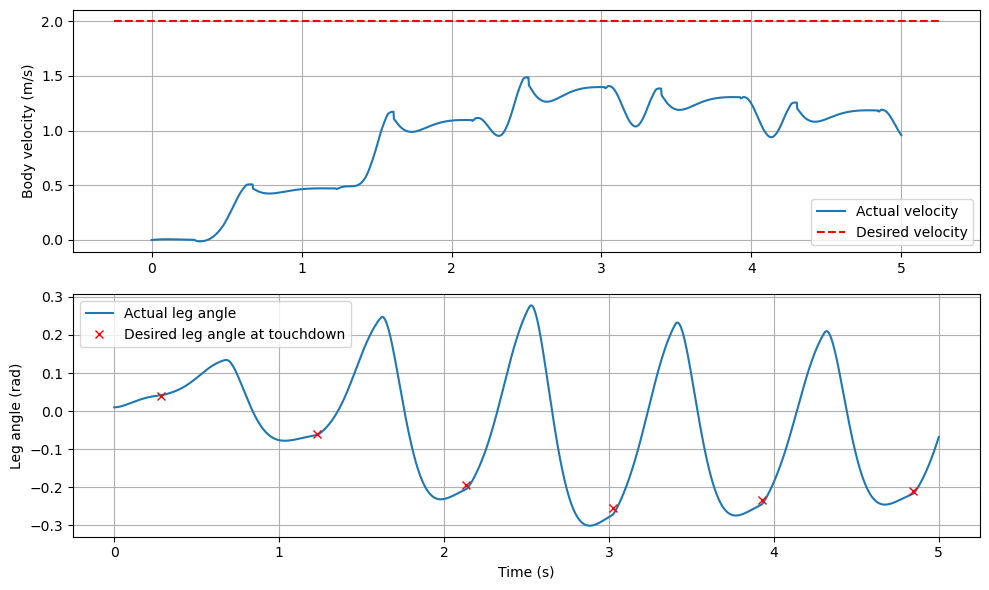

Creating animation with 120 frames...
Animation created successfully!

Simulation complete!
Final time: 5.0000 s
Final position: x=4.65 m
Distance traveled: 4.65 m


In [64]:
# Run simulation with desired forward velocity of 2 m/s
tout, yout, State, p, anim = call_hopper(tfinal=5, x_dot_des=2.0)

print(f"\nSimulation complete!")
print(f"Final time: {tout[-1]:.4f} s")
print(f"Final position: x={yout[-1, 0]:.2f} m")
print(f"Distance traveled: {yout[-1, 0] - yout[0, 0]:.2f} m")

## Display Animation

Run this cell to display the animation as an HTML5 video in the notebook.

In [65]:
# Display animation as HTML5 video (2D matplotlib)
if anim is not None:
    display(HTML(anim.to_html5_video()))
else:
    print("No animation available. Run the simulation first.")

## 3D Visualization with MeshCat

MeshCat provides an interactive 3D view of the hopper in your browser. Run the cell below to see the hopper in 3D!

In [66]:
def animate_meshcat(tout, yout, p, fps=30, depth=0.2):
    """
    Animate the hopper simulation using MeshCat 3D visualization
    
    Args:
        tout: Time array from simulation
        yout: State array from simulation
        p: Parameters object
        fps: Frames per second for animation (default: 30)
        depth: Depth of the 3D extrusion (default: 0.2)
    """
    try:
        import meshcat
        import meshcat.geometry as g
        import meshcat.transformations as tf
        from meshcat.animation import Animation
    except ImportError:
        print("MeshCat not installed. Install with: pip install meshcat")
        return None
    
    def polygon_to_mesh(vertices_in, depth, color):
        n = vertices_in.shape[1]
        
        vertices = []
        # Add all front vertices
        for i in range(n):
            vertices.append([vertices_in[0, i], -depth/2, vertices_in[2, i]])
        # Add all back vertices  
        for i in range(n):
            vertices.append([vertices_in[0, i], depth/2, vertices_in[2, i]])
        
        vertices = np.array(vertices)
        faces = []
        
        # Front: fan from vertex 0
        for i in range(1, n-1):
            faces.append([0, i, i+1])
        
        # Back: fan from vertex n (reversed)
        for i in range(1, n-1):
            faces.append([n, n+i+1, n+i])
        
        # Sides
        for i in range(n):
            next_i = (i + 1) % n
            faces.append([i, next_i, i+n])
            faces.append([next_i, next_i+n, i+n])
        
        return g.TriangularMeshGeometry(vertices, np.array(faces)), g.MeshLambertMaterial(color=color)

    # Create visualizer
    vis = meshcat.Visualizer()
    local_url = vis.url()
    
    # Check if running in Colab - improved version
    try:
        from google.colab import output
        import re
        # Extract port number more robustly
        match = re.search(r':(\d+)', local_url)
        if match:
            port = int(match.group(1))
            # Use Colab's port forwarding
            colab_url = output.eval_js(f"google.colab.kernel.proxyPort({port})")
            print(f"🌐 MeshCat (Colab): {colab_url}")
            print(f"   💡 If link doesn't auto-open, copy-paste it into a new browser tab")
            print(f"   💡 Alternative: Use the ngrok option in cell below if this doesn't work")
        else:
            print(f"🌐 MeshCat: {local_url}")
    except ImportError:
        # Not in Colab
        print(f"🌐 MeshCat (Local): {local_url}")
    except Exception as e:
        print(f"⚠️  MeshCat: {local_url}")
        print(f"   Colab port forwarding may not work. Try ngrok option below.")
        print(f"   Error: {e}")
    
    vis.delete()
    
    # Set camera for better initial view
    vis["/Cameras/default"].set_transform(
        tf.translation_matrix([0, 1.5, 5]) @ tf.rotation_matrix(-0.3, [1, 0, 0])
    )
    
    # brick1 = np.array([[0.9, 1.05, 1.05, 0.9, 0.9], [0.15, 0.15, 0.0, 0.0, 0.15]])
    # brick2 = np.array([[-1, 0], [0, 1]]) @ brick1
    # beam = np.array([[-1, -1, 1, 1], [0.15, 0.175, 0.175, 0.15]])
    # comp = np.array([[0.25, 0.25, 0.025, 0.025, -0.025, -0.025, -0.25, -0.25],
    #                     [0.15, 0.3, 0.3, 0.15, 0.15, 0.3, 0.3, 0.15]])
    # body_shape = np.hstack([brick1, brick2, beam, comp])
    # body_shape = body_shape - np.array([[0], [0.16]]) @ np.ones((1, body_shape.shape[1]))
    # leg_shape = np.array([[-0.015, -0.04, -0.04, 0.04, 0.04, 0.015, -0.015],
    #                         [-0.25, -0.25, 0.525, 0.525, -0.25, -0.25, -0.25]])
    # leg_shape = leg_shape - np.array([[0], [0.16]]) @ np.ones((1, leg_shape.shape[1]))
    # foot_shape = np.array([[0.0, -0.03, -0.03, 0.015, 0.015, -0.025, -0.025, 0.025, 0.025, -0.015, -0.015, 0.03, 0.03, 0.0],
    #                         [0.0, 0.05, 0.14, 0.14, 1.675, 1.675, 1.725, 1.725, 1.675, 1.675, 0.14, 0.14, 0.05, 0.0]])
    # Create geometry - EXACT same as 2D animation
    import numpy as np
    brick1x = np.array([0.9, 1.05, 1.05, 0.9, 0.9])
    brick1z = np.array([0.15, 0.15, 0.0, 0.0, 0.15])
    brick1y = np.zeros_like(brick1x)
    brick1 = np.array([brick1x,
                      np.zeros_like(brick1x),
                      brick1z])
    
    brick2 = np.array([[-1, 0, 0], [0, 1, 0],[0,0,1]]) @ brick1 # fliplr basically. 
    
    beamx = np.array([-1, -1, 1, 1, -1])
    beamz = np.array([0.15, 0.175, 0.175, 0.15, 0.15])
    beam  = np.array([beamx,
                      np.zeros_like(beamx),
                      beamz])

    compx = np.array([0.25, 0.25, 0.025, 0.025, -0.025, -0.025, -0.25, -0.25, 0.25])
    compz = np.array([0.15, 0.3, 0.3, 0.15, 0.15, 0.3, 0.3, 0.15, 0.15])
    comp = np.array([compx,
                    np.zeros_like(compx),
                    compz])
    body_shape = np.hstack([brick1, brick2, beam, comp])
    body_shape = body_shape - np.array([[0], [0], [0.16]]) @ np.ones((1, body_shape.shape[1])) # shift all body things by the offset 0.16 i guess. 
    
    legx = np.array([-0.015, -0.04, -0.04, 0.04, 0.04, 0.015, -0.015])
    legz = np.array([-0.25, -0.25, 0.525, 0.525, -0.25, -0.25, -0.25])
    leg_shape = np.array([legx,
                          np.zeros_like(legx),
                          legz])
    
    leg_shape = leg_shape - np.array([[0], [0], [0.16]]) @ np.ones((1, leg_shape.shape[1])) # as above. shift all.
    
    footx = np.array([0.0, -0.03, -0.03, 0.015, 0.015, -0.025, -0.025, 0.025, 0.025, -0.015, -0.015, 0.03, 0.03, 0.0])
    footz = np.array([0.0, 0.05, 0.14, 0.14, 1.675, 1.675, 1.725, 1.725, 1.675, 1.675, 0.14, 0.14, 0.05, 0.0])
    foot_shape = np.array([footx,
                           np.zeros_like(footx),
                           footz])
    
    print(f"Creating 3D meshes (depth={depth})...")
    
    # Create 3D meshes from 2D polygons. Tedious. 
    brick1_geom, brick1_mat = polygon_to_mesh(brick1, depth, 0xBFBFBF)
    brick2_geom, brick2_mat = polygon_to_mesh(brick2, depth, 0xBFBFBF)
    beam_geom, beam_mat = polygon_to_mesh(beam, depth, 0xBFBFBF)
    comp_geom, comp_mat = polygon_to_mesh(comp, depth, 0xBFBFBF)
    leg_geom, leg_mat = polygon_to_mesh(leg_shape, depth, 0xBFBFBF)
    foot_geom, foot_mat = polygon_to_mesh(foot_shape, depth, 0xBFBFBF)
    
    vis["hopper"]["body"]["brick1"].set_object(brick1_geom, brick1_mat)
    vis["hopper"]["body"]["brick2"].set_object(brick2_geom, brick2_mat)
    vis["hopper"]["body"]["beam"].set_object(beam_geom, beam_mat)
    vis["hopper"]["body"]["comp"].set_object(comp_geom, comp_mat)
    vis["hopper"]["leg"].set_object(leg_geom, leg_mat)
    vis["hopper"]["foot"].set_object(foot_geom, foot_mat)
    
    # Ground
    import numpy as np
    # Create a checkerboard using multiple boxes
    num_squares = 20
    square_size = 2.0

    for i in range(num_squares):
        for j in range(num_squares):
            color = 0xffffff if (i + j) % 2 == 0 else 0x505050
            vis[f"ground/square_{i}_{j}"].set_object(
                g.Box([square_size, square_size, 0.05]),
                g.MeshLambertMaterial(color=color)
            )
            vis[f"ground/square_{i}_{j}"].set_transform(
                tf.translation_matrix([
                    (i - num_squares/2) * square_size + square_size/2,
                    (j - num_squares/2) * square_size + square_size/2,
                    0
                ])
            )

    # Create checkerboard pattern
    # checker_size = 512  # Texture resolution
    # texture_data = np.zeros((checker_size, checker_size, 3), dtype=np.uint8)
    # square_size = checker_size // 16  # 16x16 checkerboard

    # for i in range(checker_size):
    #     for j in range(checker_size):
    #         if ((i // square_size) + (j // square_size)) % 2 == 0:
    #             texture_data[i, j] = [255, 255, 255]  # White
    #         else:
    #             texture_data[i, j] = [80, 80, 80]  # Dark gray

    # # Create the ground with texture
    # vis["ground"].set_object(
    #     g.Box([40, 40, 0.05]),
    #     g.MeshLambertMaterial(
    #         color=0xffffff,
    #         map=g.PngImage(texture_data)
    #     )
    # )

    # vis["ground"].set_object(g.Box([40, 2, 0.05]), g.MeshLambertMaterial(color=0x808080))
    vis["ground"].set_transform(tf.translation_matrix([0, 0, -0.25]))
    
    print(f"✓ Geometry created")
    
    # Prepare animation
    ds = max(1, round(len(tout) / (fps * (tout[-1] - tout[0]))))
    tout_vid = tout[::ds]
    yout_vid = yout[::ds, :]
    
    print(f"📹 Recording {len(tout_vid)} frames at {fps} fps...")
    
    anim = Animation(default_framerate=fps)
    
    # Animate - EXACT same transforms as 2D code
    for i, (t, q) in enumerate(zip(tout_vid, yout_vid)):
        x_foot = q[0]
        z_foot = q[1] 
        phi_leg = q[2]
        phi_body = q[3]
        leg_length = q[4]
        
        # Compute hip position EXACTLY as 2D code does
        # hip = [0, leg_length] in leg frame
        # rotate by phi_leg, translate by foot position
        cos_leg = np.cos(phi_leg)
        sin_leg = np.sin(phi_leg)
        x_hip = x_foot + leg_length * sin_leg
        z_hip = z_foot + leg_length * cos_leg
        
        with anim.at_frame(vis, i) as frame:
            # Foot: rotate by phi_leg around origin, translate to foot position
            # Equivalent to: Foot = rot @ foot_shape + [[x_foot], [y_foot]]
            foot_tf = tf.translation_matrix([x_foot, 0, z_foot]) @ \
                      tf.rotation_matrix(phi_leg, [0, 1, 0])
            frame["hopper"]["foot"].set_transform(foot_tf)
            
            # Leg: rotate by phi_leg around origin, translate to hip position
            # Equivalent to: Leg = rot @ leg_shape + hip.reshape(2,1)
            leg_tf = tf.translation_matrix([x_hip, 0, z_hip]) @ \
                     tf.rotation_matrix(phi_leg, [0, 1, 0])
            frame["hopper"]["leg"].set_transform(leg_tf)
            
            # Body: rotate by phi_body around origin, translate to hip position
            # Equivalent to: Body = rot_body @ body_shape + hip.reshape(2,1)
            body_tf = tf.translation_matrix([x_hip, 0, z_hip]) @ \
                      tf.rotation_matrix(phi_body, [0, 1, 0])
            frame["hopper"]["body"].set_transform(body_tf)
    
    print(f"✓ Recorded {len(tout_vid)} frames")
    
    # Set animation
    vis.set_animation(anim, play=False, repetitions=0)
    vis["/Grid"].set_property("visible", False)
    vis["/Cameras/default/rotated/<object>"].set_property(
        "position", 
        [0, -3, 10]
    )

    # Set what the camera is looking at (target point)
    vis["/Cameras/default"].set_property(
        "target",
        [0, 0, 0]  # Looking at the origin
    )
    print("\n" + "="*60)
    print("✅ Animation ready!")
    print("="*60)
    print("Open the MeshCat URL above in your browser")
    print("Look for animation controls (may be in Animations panel or bottom)")
    print("="*60)
    
    return vis

# Run MeshCat animation
try:
    vis = animate_meshcat(tout, yout, p, fps=30, depth=0.2)
    if vis:
        print(f"\n🔗 {vis.url()}")
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/
🌐 MeshCat (Local): http://127.0.0.1:7006/static/
Creating 3D meshes (depth=0.2)...
✓ Geometry created
📹 Recording 153 frames at 30 fps...
✓ Recorded 153 frames

✅ Animation ready!
Open the MeshCat URL above in your browser
Look for animation controls (may be in Animations panel or bottom)

🔗 http://127.0.0.1:7006/static/


## About the Raibert Controller

This simulation implements the classic Raibert hopping controller with three key control strategies:

1. **Forward Speed Control via Foot Placement**: The foot is placed ahead or behind the body to control forward velocity. The desired foot placement angle is computed based on the current velocity error and the estimated stance time.

2. **Hopping Height Control via Thrust Timing**: A thrust force is applied during the stance phase to maintain hopping height. The thrust duration is limited to prevent over-extension.

3. **Body Attitude Control**: During stance, the body angle is controlled to maintain stability and ensure proper energy transfer.

The controller uses a finite state machine (FSM) with three states:
- **COMPRESSION**: Leg is compressing after touchdown
- **THRUST**: Active thrust is applied to the leg
- **FLIGHT**: Robot is in the air

For more information, see:
- Raibert, M. H. (1986). Legged Robots That Balance. MIT Press.
- Tedrake, R. (2024). Underactuated Robotics. MIT Press.

In [67]:
# OPTIONAL: ngrok alternative for Colab
# Uncomment the lines below if Colab's built-in port forwarding doesn't work

# !pip install pyngrok
from pyngrok import ngrok, conf
import re

# Set your ngrok auth token (get from https://dashboard.ngrok.com/get-started/your-authtoken)
# Replace YOUR_TOKEN_HERE with your actual token from ngrok dashboard
ngrok.set_auth_token("YOUR_TOKEN_HERE")

# Extract port from meshcat URL
if vis:
    local_url = vis.url()
    match = re.search(r':(\d+)', local_url)
    if match:
        port = int(match.group(1))

        # IMPORTANT: Use bind_tls=True to ensure HTTPS (required for WebSocket support)
        # This fixes the "Can 'Upgrade' only to 'WebSocket'" error
        public_url = ngrok.connect(port, bind_tls=True)

        print(f"🌐 Public MeshCat URL (via ngrok): {public_url}")
        print(f"   This link will work from anywhere!")
        print(f"   Note: The URL uses HTTPS, which properly supports WebSocket connections")
    else:
        print("Could not extract port from meshcat URL")

🌐 Public MeshCat URL (via ngrok): NgrokTunnel: "https://genial-deandrea-unthreateningly.ngrok-free.dev" -> "http://localhost:7006"
   This link will work from anywhere!
   Note: The URL uses HTTPS, which properly supports WebSocket connections


## Alternative: Use ngrok for Colab (if built-in forwarding doesn't work)

If the MeshCat link above doesn't work in Colab, you can use ngrok to create a public tunnel.

**Why ngrok?** MeshCat uses WebSockets for real-time 3D visualization. Colab's built-in port forwarding sometimes doesn't handle WebSocket connections properly.

**Setup:**
1. Sign up for a free ngrok account at https://ngrok.com
2. Get your auth token from https://dashboard.ngrok.com/get-started/your-authtoken
3. In the cell above, replace `YOUR_TOKEN_HERE` with your token and uncomment the code

**Important:** The code uses `bind_tls=True` which creates an HTTPS tunnel. This is required for WebSocket support and prevents the "Can 'Upgrade' only to 'WebSocket'" error.